Edgic Analysis
==


### Connect to Reddit API
Establish connection to Reddit via the Python Reddit API Wrapper

In [30]:
import praw
import re
import pandas as pd
from praw.models import MoreComments
import numpy as np
from datetime import datetime, timezone
import json
from collections import OrderedDict

# Track date of data pull
pull_date = datetime.now().strftime("%b %d %Y %H:%M:%S")

# Create connection to Reddit via PRAW
fp = open('./settings.json')
settings = json.load(fp).get('praw')
reddit = praw.Reddit(client_id = settings.get('client_id'),
                    client_secret = settings.get('client_secret'),
                    user_agent = settings.get('user_agent'),
                    username = settings.get('username'),
                    password = settings.get('password'))
subreddit = reddit.subreddit('edgic')

fp = open('./edgic-seasons.json')
seasons = json.load(fp)

readData = True

### Pull all required data

In [145]:
pattern1 = re.compile(r'[0-9]*?\.?[0-9]*?\s+:\s+.+$', re.MULTILINE)
pattern2 = re.compile(r'[a-zA-Z ]*?\s+-\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)
pattern3 = re.compile(r'[a-zA-Z ]*?\s+:\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)
pattern4 = re.compile(r'[a-zA-Z ]*?\s*:\s+[0-9]*?\.?[0-9]+?$', re.MULTILINE)

edgic_results = {}
for season in seasons.values():
    season_results = OrderedDict()
    submissions = subreddit.search("Edgic Results, "+season,sort='new')
    print("-------------")
    print(season)
    print("-------------")
    for sub in submissions:
        if str(sub.author) == "DesertScorpion4":
            title = sub.title.replace("Edgic Results","").replace(season,"").replace(":","").strip()
            text = None
            if pattern1.search(sub.selftext):
                text = {t.split(":")[1].strip() : float(t.split(":")[0].strip()) for t in pattern1.findall(sub.selftext)}
            elif pattern2.search(sub.selftext):
                text = {t.split("-")[0].strip() : float(t.split("-")[1].strip()) for t in pattern2.findall(sub.selftext)}
            elif pattern3.search(sub.selftext):
                text = {t.split(":")[0].strip() : float(t.split(":")[1].strip()) for t in pattern3.findall(sub.selftext)}
            elif pattern4.search(sub.selftext):
                text = {t.split(":")[0].strip() : float(t.split(":")[1].strip()) for t in pattern4.findall(sub.selftext)}
            
            if(not text):
                print(f"Pattern match not found for the following submission:\nTitle: {title}\nBody:\n{sub.selftext}")
                print("===========")
            season_results[title] = text
    edgic_results[season] = OrderedDict(list(season_results.items())[::-1])
    
print(edgic_results)

-------------
Island of the Idols
-------------
-------------
EoE
-------------
Pattern match not found for the following submission:
Title: Finale
Body:
[Spreadsheet](https://docs.google.com/spreadsheets/d/1D4N86PInqKB-6dEeCzJrMIa1mhGubjhSZcZC27Ng1xo/edit#gid=0)

[Raw Results](https://docs.google.com/forms/d/1fj8RT6_ciqofkq6BJr8wrJ4XDR5tTYYxW4wrPbyIVGE/viewanalytics)
-------------
DvG
-------------
Pattern match not found for the following submission:
Title: Finale
Body:
[Spreadsheet](https://docs.google.com/spreadsheets/d/10E8viO6_zMxLEaqRO3ZVtLGRAOIpFJ5n33lClDLaius/edit#gid=0)

[Raw Results](https://docs.google.com/forms/d/1ES8e9oqKQfz8joWV6K4pBc_ufT2DoibKPSN-inHE7jc/viewanalytics)


-------------
Ghost Island
-------------
Pattern match not found for the following submission:
Title: Finale
Body:
[Spreadsheet](https://docs.google.com/spreadsheets/d/1tS6CmA8SnauhjlXMDrpcReqG8Wnr1rDeXRioL6ya6P8/edit#gid=0)

[Raw Results](https://docs.google.com/forms/d/e/1FAIpQLScI7HI11XV_MD1eL9yBpYLy

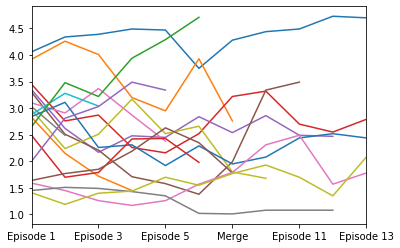

In [119]:
# Make graph for IoI
IoI = edgic_results["Island of the Idols"]
df = pd.DataFrame(IoI, columns=IoI.keys())
df.transpose()
df.transpose().plot(legend=False)

### Save results

In [140]:
for season in seasons.values():
    data = edgic_results[season]    
    df = pd.DataFrame(data, columns=data.keys())
    # Save csv for reference
    df_format = df.transpose().reset_index().rename(columns={'index':'Episode'})
    df_format.to_csv(f'./data/{season}_contender_rankings.csv', header=True, index=None)

In [600]:
season = "EoE"
df = pd.read_csv(f"./data/{season}_contender_rankings.csv")
results = pd.read_csv("./data/contestants-results.csv")
df_pivot = pd.DataFrame(columns=['Episode','name','rank','finish','vote out','finalist'])
for col in df.columns:
    df_new = pd.DataFrame(columns=['Episode','name','rank','finish','vote out','finalist'])
    if not col == 'Episode':
        res = results.loc[(results["Season"]==season) & (results['name']==col)].set_index(["name", "Vote Out"])
        res['last episode'] = ['Finale' if x=='FTC' else x for x in res.reset_index()['Vote Out']]
        df_new['Episode'] = df['Episode']
        df_new['name'] = col
        df_new['rank'] = df[col]
        df_tmp=pd.merge(df_new, res.reset_index()[['name','last episode','Vote Out']], how='left', left_on=['name','Episode'], right_on=['name','last episode'])
        df_tmp2=pd.merge(df_new, res.reset_index()[['name','Rank']].dropna(), how='left', left_on=['name'], right_on=['name'])
        df_new['vote out'] = df_tmp['last episode']==df_tmp['Episode']
        df_new['FTC'] = df_tmp['Vote Out']=='FTC'
        df_new['finish'] = df_tmp2['Rank']
        df_new['finalist'] = df_new['finish']<6
        df_pivot = pd.concat([df_pivot, df_new], sort=False)
data = df_pivot.reset_index(drop=True)
# print(data.loc[data['vote out']==True])
for x in data.loc[data['vote out']==True].index.values:
    if not data.loc[x,'rank']>0:
        data.loc[x,'rank'] = data.loc[x-1,'rank']
# print(data.loc[data['vote out']==True])
data['finalist_col'] = [x[1]['finish'] if x[1]['finalist']==True else 'None' for x in data.iterrows()]

### Set plot theme using plotnine

In [601]:
from plotnine import *

# Define colors
color_background = "white"
color_text = "#22211d"

# Define the theme to be used on all graphs
my_theme = (

    # Begin construction of chart
    theme_bw(base_size=15) +

    # Format background colors
    theme(panel_background = element_rect(fill=color_background, color=color_background)) +
    theme(plot_background  = element_rect(fill=color_background, color=color_background)) +
    theme(panel_border     = element_rect(color=color_background)) +
    theme(strip_background = element_rect(fill=color_background, color=color_background)) +

    # Format the grid
    theme(panel_grid_major_y = element_blank()) +
    theme(panel_grid_minor_y = element_blank()) +
    theme(axis_ticks         = element_blank()) +

    # Format the legend
    theme(legend_position = "none") +

    # Format title and axis labels
    theme(plot_title       = element_text(color=color_text, size=20, weight = "bold")) +
    theme(axis_title_x     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_title_y     = element_text(size=10, color="black", weight = "bold")) +
    theme(axis_text_x      = element_text(size=12, vjust=1, hjust=1, color = color_text,rotation=45)) +
    theme(axis_text_y      = element_text(size=12, color = color_text)) +
    theme(strip_text       = element_text(face = "bold")) +

    # Plot margins
    theme(figure_size = (12,6))
    )


### Create plot
Create plots to visualize the data. Show the contender rankings over time, transposed with the final result and episode voted out.

In [602]:
def base_fig(data, color_col,cmap):
    episodes = pd.Categorical(data['Episode'], categories=data['Episode'].unique().tolist())
    data = data.assign(episode_ord = episodes)
    return(
        ggplot(data=data, mapping=aes(x='episode_ord', y='rank', group='name')) +
        geom_line(aes(color=color_col, alpha = 1), size = 2) + 
        geom_point(data=data.loc[data['vote out']==True], mapping=aes(y='rank', color=color_col), shape='.', size=9) +
        geom_point(data=data.loc[data['vote out']==True], mapping=aes(y='rank'), color="#FFFFFF", shape='.', size=3) +
        geom_point(data=data.loc[data['FTC']==True], mapping=aes(y='rank', color=color_col), shape='*', size=9) +
        geom_point(data=data.loc[data['FTC']==True], mapping=aes(y='rank'), color="#FFFFFF", shape='*', size=3) +
        geom_label(data=data.loc[data['vote out']==True], mapping=aes(y='rank', label='name', color=color_col), ha='left', nudge_x=.15, size=7) +
        scale_y_continuous(limits=[1,5], breaks=range(1,6,1)) + 
        labs(x="Episode", y="Contender Rating",title="Contender Rating of Contestants") +
        scale_color_manual(cmap)
    )

/anaconda3/lib/python3.7/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 7 rows containing missing values.
  warn(msg.format(n1-n2), PlotnineWarning)


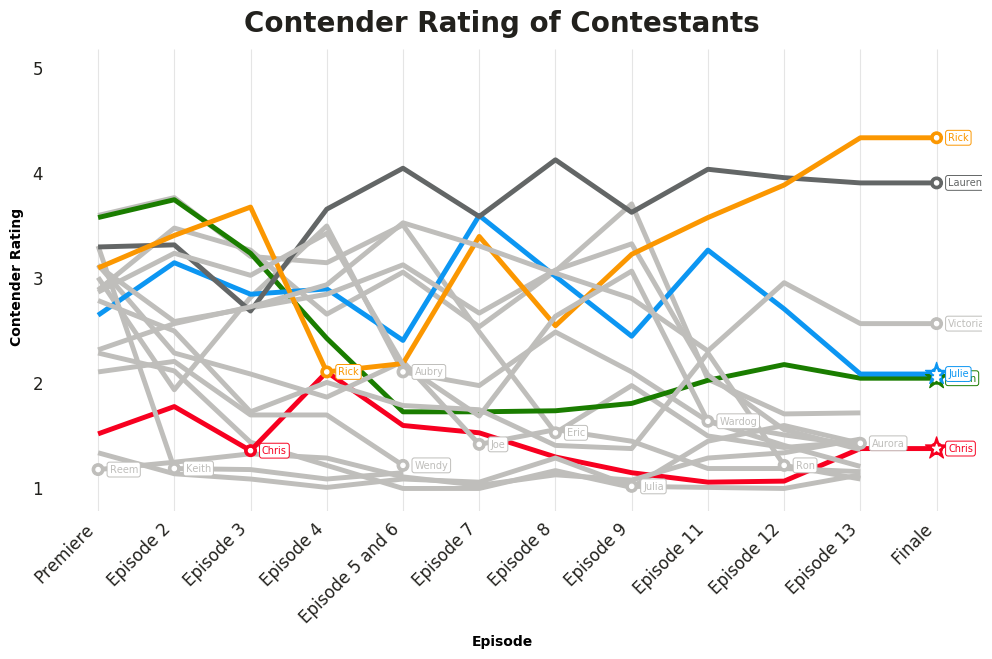

<ggplot: (330469973)>

In [603]:
cmap_tmp = {1:"#F70020",2:"#1A7D00",3:"#0C96F2",4:"#FB9701",5:"#636666",6:"#87603E","None":"#BFBEBB"}
base_fig(data,'finalist_col',cmap_tmp) + my_theme

In [593]:
data.loc[data['finalist_col']!='None']

,Episode,name,rank,finish,vote out,finalist,FTC,finalist_col
13,Premiere,Wendell,NaN,1.0,False,True,False,1
14,Episode 3,Wendell,3.63,1.0,False,True,False,1
15,Episode 4,Wendell,3.30,1.0,False,True,False,1
16,Episode 5,Wendell,2.71,1.0,False,True,False,1
17,Episode 6,Wendell,3.38,1.0,False,True,False,1
...,...,...,...,...,...,...,...,...
177,Episode 10,Angela,1.32,4.0,False,True,False,4
178,Episode 11,Angela,1.02,4.0,False,True,False,4
179,Episode 12,Angela,1.24,4.0,False,True,False,4
180,Episode 13,Angela,1.02,4.0,False,True,False,4
